In [ ]:
# run following lines if cannot successfully import

# pip install spacy
# python -m spacy download en_core_web_lg
# pip install wordcloud

In [1]:
# import necessary package
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
import seaborn as sns

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Plotting tools
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import math

# Creating a spaCy object
nlp = spacy.load('en_core_web_lg')

# Pre-processing

In [2]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# define lemmalization function
def lemmatization(texts):
    
    # initialize the output
    texts_out = []
    
    # for every notes in notes list, do lemmatization
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([word.lemma_ for word in doc]) 
    return texts_out

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
def create_customized_sw_list():
    
    # use NER to customize stop words list 1
    stop_words_ner_list=[]

    for i in range(1321):
        doc = nlp(" ".join(notes_words_lemmatized[i]))
        for j in doc.ents:
            stop_words_ner_list.extend(str(j).split())

    print('number of stop words recognized by spacy: ', len(stop_words_ner_list))
    
    # set a list 2 of other words we don't want to include
    customized_sw = ["'s",'refinery','source','sinopec','unit','pdvsa','trader','nigeria','dangote','italy',
                    'total','jxtg','italy','petrochina','idemitsu','marathon','sannazzaro','pbf','korea','cosmo',
                    'ioc','crp','huizhou','cnooc','hainan','complex','repsol','shell','milazzo','isab','sarroch',
                    'chevron','augusta','exxonmobil','bp','dutch','rfcc','say','hydrocracker','adnoc','imo',
                    'ruwais','petronor','druzhba','coker','ramco','south','rhineland','petrochemical','liaoyang',
                    'eni','star','sannazzaro','omsk','belarus','feyzin','mozyr','bilbao','perni','aramco','russia',
                    'malaysia']
    print('number of stop words recognized manually: ', len(customized_sw))
    
    # append the list 2 to stop words list 1
    stop_words_ner_list.extend(customized_sw)

    # get the unique stop words list
    stop_words_ner_list_new = list(set(stop_words_ner_list))
    print('number of unique stop words: ', len(stop_words_ner_list_new))
    
    return stop_words_ner_list_new

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# Remove customize stop words in title_after_lemma
def get_cleaned_notes(texts):
    
    # get cleaned words without stop words
    notes_words_cleaned = [[word for word in sent if word not in stop_words_ner_list_new] for sent in texts]
    
    # get a list of string from nested list
    notes_words_cleaned_sent = []
    for item in notes_words_cleaned:
        notes_words_cleaned_sent.append(" ".join(item))
    
    return notes_words_cleaned_sent

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# main part

# import data
news = pd.read_csv('news_for_classification_final.csv')
notes  = news.notes.values.tolist()

# break sentences to words
notes_words = list(sent_to_words(notes))

# get title after lemmatization
notes_words_lemmatized = lemmatization(notes_words)

# get customized stop words list
stop_words_ner_list_new = create_customized_sw_list()

# get final sentences for modelling
notes_words_cleaned_sent = get_cleaned_notes(notes_words_lemmatized)
notes_words_cleaned_sent[:10]

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


number of stop words recognized by spacy:  7658
number of stop words recognized manually:  62
number of unique stop words:  425


['note hestya energy aim operation currently wilhelmshaven it netherland base have previously it would operate which it decline name tolling agreement accord it be vacuum distillation which be likely be restart use produce low sulfur fuel oil international maritime organization requirement low sulfur bunker fuel',
 'note southern have successfully complete maintenance north plant have be schedule work union tell global platt north section be offline during maintenance upgrade work be carry out be not immediately available confirm work have be complete',
 'note api central coastal town falconara marittima which have be schedule carry out maintenance work vacuum pipe still vps tower crack have delay plan without provide further information wasn immediately available comment matter work have originally be due through maintenance upgrade work be involve plant thermal crack well tower internal vps crude',
 'note large refiner grupa lotos average model refining margin be accord figure publis

In [14]:
len(notes_words_cleaned_sent)

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1321

# Training LDA model using sklearn

In [15]:
# get feature matrix
vectorizer = CountVectorizer(min_df=10, max_df=0.9, stop_words='english')
data_vectorized = vectorizer.fit_transform(notes_words_cleaned_sent)

# get lda model results
lda = LatentDirichletAllocation(n_components=6, learning_decay=0.9, verbose=True)
data_lda = lda.fit_transform(data_vectorized)

# get term names for further exploration
terms = vectorizer.get_feature_names()

# visualization using pyLDAvis
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')

# Save the output to the html file
pyLDAvis.save_html(dash, "topic_viz.html")

# evaluation of the model
print("Perplexity: ", lda.perplexity(data_vectorized))
print("Score: ", lda.score(data_vectorized))

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Perplexity:  285.10914948142926
Score:  -148472.6853804694


# Topic number choosing

In [16]:
# Define Search Param
search_params = {'n_components': [2, 6, 10, 14, 18], 'learning_decay': [.5, .7, .9]}

# Init the model
lda_multiple = LatentDirichletAllocation()

# Init Grid Search class
model = GridSearchCV(lda_multiple, search_params)

model.fit(data_vectorized)
best_lda_model = model.best_estimator_
print("Best model's params: ", model.best_params_)
print("Best log likelihood score: ", model.best_score_)
print("Model perplexity: ", best_lda_model.perplexity(data_vectorized))

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best model's params:  {'learning_decay': 0.5, 'n_components': 2}
Best log likelihood score:  -31797.380658128455
Model perplexity:  315.45362958805964


C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='param_n_components', ylabel='mean_test_score'>

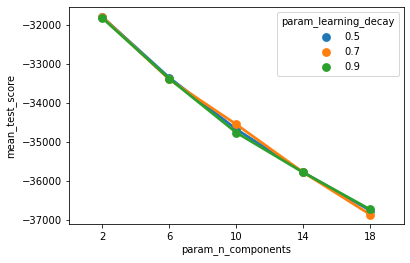

In [17]:
# plot
df_cv_results = pd.DataFrame(model.cv_results_)
df_cv_results.to_csv("LDAGridSearchResults.csv", header=True, index=False, encoding='utf-8')

sns.pointplot(x="param_n_components", y="mean_test_score", hue="param_learning_decay", data=df_cv_results)

# Topic distribution

In [18]:
def get_dominant_topic(lda_output):
    
    # create a dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output,6), columns=topicnames, index=docnames)

    # dominant topic
    df_document_topic['dominant_topic'] = np.argmax(df_document_topic.values, axis=1)

    return df_document_topic

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
def get_tp_distribution(df_document_topic):
    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
    df_topic_distribution.columns = ['Topic Num', 'Num Documents']
    return df_topic_distribution

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# Styling
def make_bold(val):
    weight = 700 if val > .2 else 400
    return 'font-weight: {weight}'.format(weight=weight)

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# Create a document to topic matrix
lda_output = lda.transform(data_vectorized)

# column names
topicnames = ['Topic_' + str(i) for i in range(lda.n_components)]

# index names
docnames = ['Doc_' + str(i) for i in range(len(notes_words_cleaned_sent))]

df_document_topic = get_dominant_topic(lda_output)
df_document_topics = df_document_topic.head(15).style.applymap(make_bold)
df_document_topics

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
df_topic_distribution = get_tp_distribution(df_document_topic)
df_topic_distribution

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic Num  Num Documents
0          4            425
1          2            281
2          0            222
3          1            150
4          3            137
5          5            106

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='dominant_topic', ylabel='count'>

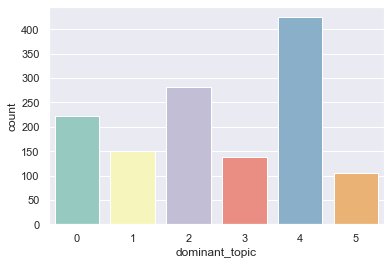

In [24]:
sns.set_theme(style="darkgrid")
sns.countplot(df_document_topic.dominant_topic, palette="Set3")

# Label ratio of each topic

In [27]:
def get_label_ratio():
    
    # init index list
    l = [[], [], [], [], [], []]
    
    # get the index list of each topic
    for i in range(len(notes_words_cleaned_sent)):
        l[df_document_topic['dominant_topic'][i]].append(i)
        
    # init label ratio list
    label_ratio = []
    
    # get the results
    for i in range(6):
        ratio = 0
        for j in range(len(l[i])):
            ratio += int(news.iloc[l[i][j]][3])
        ratio = ratio/len(l[i])
        label_ratio.append(ratio)
    
    # get the dataframe of the ratio
    d = {'topic num': [0,1,2,3,4,5]}
    label_ratio_res = pd.DataFrame(data = d)
    label_ratio_res['label ratio'] = label_ratio
    
    return label_ratio_res

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
label_res = get_label_ratio()
label_res

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic num  label ratio
0          0     0.135135
1          1     0.400000
2          2     0.423488
3          3     0.401460
4          4     0.877647
5          5     0.462264

# Topic keywords

In [29]:
def get_topic_keywords(lda_model, x, y):
    # Topic - Keyword matrix
    df_topic_keywords = pd.DataFrame(lda_model.components_)

    # assign column and index
    df_topic_keywords.columns = vectorizer.get_feature_names()
    df_topic_keywords.index = topicnames
    
    # select first x words in the first y rows to visualize
    df_topic_keywords_fxy = df_topic_keywords.iloc[:,:x].head(y).style.applymap(make_bold)
    return df_topic_keywords_fxy

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# Show top n keywords for each topic
def show_topics(vectorizer = vectorizer, lda_model = lda, n_words = 15):
    
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    
    # Topic - Keywords Dataframe
    topic_keywords_top = pd.DataFrame(topic_keywords)
    topic_keywords_top.columns = ['Word '+str(i) for i in range(topic_keywords_top.shape[1])]
    topic_keywords_top.index = ['Topic '+str(i) for i in range(topic_keywords_top.shape[0])]
    
    return topic_keywords_top

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
df_topic_keywords = get_topic_keywords(lda, 10, 15)
df_topic_keywords

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
df_topic_keywords_top = show_topics()
df_topic_keywords_top

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Word 0  Word 1    Word 2    Word 3    Word 4      Word 5  \
Topic 0        crude     oil      fuel  pipeline  increase  production   
Topic 1     capacity  report  refining    accord    global       platt   
Topic 2          oil  export      plan     crude   product    gasoline   
Topic 3        union  strike     local    report       oil   operation   
Topic 4  maintenance    work   restart      plan    accord       plant   
Topic 5       market   plant      plan     coast    global       platt   

               Word 6     Word 7    Word 8     Word 9   Word 10   Word 11  \
Topic 0       produce     sulfur   project   complete  capacity  gasoline   
Topic 1          work  venezuela   project      plant   upgrade   include   
Topic 2  distillation      state  official   capacity    gasoil      shut   
Topic 3          rate     follow     offer     expect    medium   product   
Topic 4       comment   schedule      shut  available     carry    filing   
Topic 5          site       tell    export      socar     cargo    accord   

           Word 12   Word 13      Word 14  
Topic 0     diesel       low       launch  
Topic 1    operate      tell       locate  
Topic 2       fuel      corp  maintenance  
Topic 3        run    affect         time  
Topic 4  catalytic  shutdown  immediately  
Topic 5     expect    outage    operation

# Clustering

In [33]:
def cluster_tp(lda_output, n):
    # Construct the k-means clusters
    clusters = KMeans(n_clusters = n, random_state=100).fit_predict(lda_output)

    # Build the Singular Value Decomposition(SVD) model
    svd_model = TruncatedSVD(n_components=2)  # 2 components
    lda_output_svd = svd_model.fit_transform(lda_output)

    # X and Y axes of the plot using SVD decomposition
    x = lda_output_svd[:, 0]
    y = lda_output_svd[:, 1]

    # Weights for the 15 columns of lda_output, for each component
    print("Component's weights: \n", np.round(svd_model.components_, 2))

    # Percentage of total information in 'lda_output' explained by the two components
    print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))
    
    return x, y, clusters

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
def show_clusters(x, y, clusters):
    plt.figure(figsize=(12, 12))
    plt.scatter(x, y, c=clusters)
    plt.ylabel('Component 2')
    plt.xlabel('Component 1')
    plt.title("Segregation of Topic Clusters", )

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Component's weights: 
 [[ 0.39  0.36  0.33  0.27  0.64  0.36]
 [-0.26 -0.36 -0.24 -0.16  0.77 -0.36]]
Perc of Variance Explained: 
 [0.02 0.28]


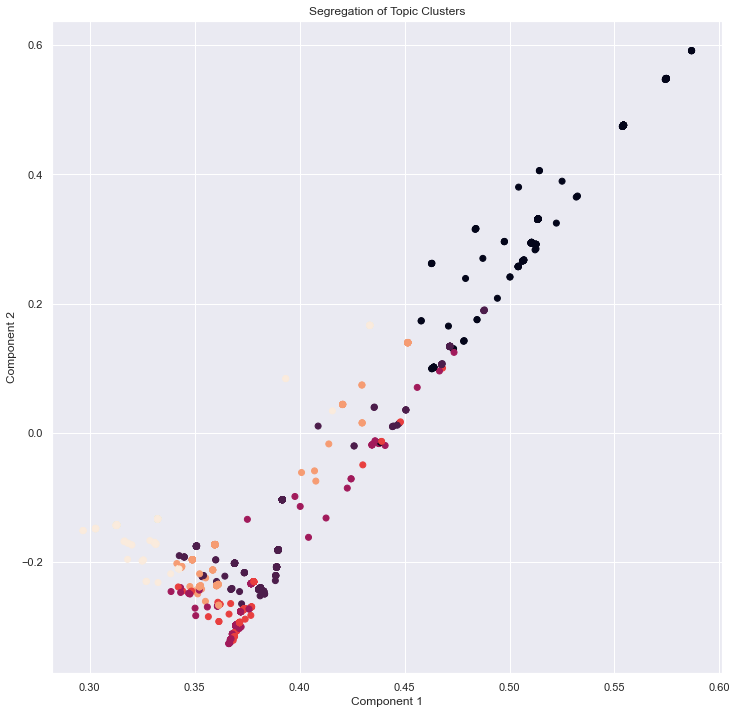

In [26]:
x, y, clusters = cluster_tp(lda_output, 6)
show_clusters(x, y, clusters)

# Word cloud

In [35]:
def get_topic_wc_list(n, lda):
    # declaring number of terms we need per topic
    terms_count = n

    # init topic word cloud list
    topic_wc = []
    
    for idx, topic in enumerate(lda.components_):
        
        # count top n words df for each topic
        abs_topic = abs(topic)
        topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
        topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
        topic_words = []
        
        # get the list
        for i in range(terms_count):
            topic_words.append(topic_terms_sorted[i][0])
        
        # initial df dictionary
        dict_word_frequency = {}
        
        # get the dictionary
        for i in range(terms_count):
            dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]
        
        # get dictionary for all topics
        topic_wc.append(dict_word_frequency)
    
    return topic_wc

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
def draw_wc(res):
    # init word cloud style
    wcloud = WordCloud(background_color="white", mask=None, max_words=100,\
                       max_font_size=60, min_font_size=10, prefer_horizontal=0.9,
                       contour_width=3, contour_color='black')
    
    # prepare plot in rows with 2 patterns per row
    n = len(res)
    cols = 2
    rows = math.ceil(n / cols)    
    fig, axes = plt.subplots(rows, cols, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = topic_wc[i]
        wcloud.generate_from_frequencies(topic_words)
        plt.gca().imshow(wcloud, interpolation='bilinear')
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    
    # cancel comment out the following line if want to export
    plt.savefig("Topic Results.png")
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


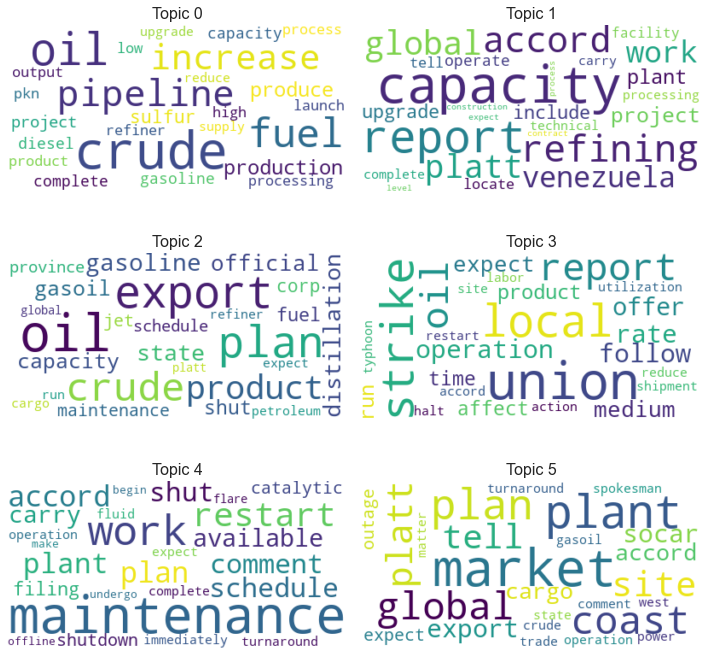

In [37]:
# get topic word cloud list
topic_wc = get_topic_wc_list(25, lda)

draw_wc(topic_wc)